##Purchase Amount Prediction (Spark ML) Project

##Done By: Ashwath Bala S

Table of Contents:

1.Problem Statement

2.Data Dictionary

3.Loading the Required Libraries

4.Loading the Train and Test Dataset

5.Univariate Analysis of the Target Variable

6.Missing Value Treatment

7.Label Encoding

8.One-Hot Encoding

9.Data Transformation

10.Model Building

11.Making Predictions on the Test Data

12.Grid Search CV - Model Improvement

13.Making Predictions on the Best Model

14.Spark ML Pipeline


##1.Problem Statement

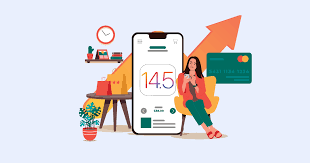

 A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.

The data set also contains customer demographics (age, gender, marital status,city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

##2. Data Dictionary

User_ID: A unique identifier for each user.

Product_ID: A unique identifier for each product.

Gender: The gender of the customer.

Age: The age range of the user.

Occupation: The occupation code of the user.

City_Category: The category of the city.

Stay_In_Current_City_Years: The number of years the user has stayed in the current city.

Marital_Status: The marital status of the user.

Product_Category_1: The main product category code.

Product_Category_2: The secondary product category code.

Product_Category_3: The tertiary product category code.

Purchase: The purchase amount (target variable).

##3. Loading the Required Libraries

In [1]:
# Installing PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=89ffa837292165b3ba877a5a98f56635c0029c9525f04b8aa33ba8ed421a39f1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Importing the Necessary Libraries

from pyspark import keyword_only
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.sql.functions import when, col, log1p

##4. Loading the Train and Test Dataset

In [3]:
# Creating a spark session
spark = SparkSession.builder.getOrCreate()

In [4]:
# Reading the data

# Reading the train data
train_data = spark.read.csv("train.csv",inferSchema=True, header=True)

# Reading the test data
test_data  = spark.read.csv("test.csv", inferSchema=True, header=True)

In [5]:
# Checking the Schema

# Data type of the train data columns
train_data.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)



In [6]:
# Data type of the test data columns
test_data.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)



##5. Univariate Analysis of Target Variable

In [7]:
# Univariate Analysis for Target Variable

# Specifying the Target Variable
target_variable_column = "Purchase"

# Calculating the number of data points in each category and their percentage
target_variable_counts = train_data.groupBy(target_variable_column).agg(
    F.count(target_variable_column).alias("Count"),
    (F.count(target_variable_column) / train_data.count() * 100).alias("Percentage")
)

# Displaying the results
print(f"Univariate Analysis for '{target_variable_column}':")
target_variable_counts.show()

Univariate Analysis for 'Purchase':
+--------+-----+--------------------+
|Purchase|Count|          Percentage|
+--------+-----+--------------------+
|   11458|   57|0.010362355199720763|
|    3794|   26|0.004726688336714733|
|   15957|   28|0.005090279747231251|
|    7880|  134|0.024360624504606705|
|    2122|   32|0.005817462568264287|
|    8086|  151|0.027451151493997104|
|    9852|   89| 0.01617981776798505|
|    7982|  160| 0.02908731284132144|
|    5300|  131|0.023815237388831925|
|   11858|   48| 0.00872619385239643|
|    8592|   98| 0.01781597911530938|
|    8638|  109| 0.01981573187315023|
|   15447|   88| 0.01599802206272679|
|    5156|  103|0.018724957641600676|
|   15619|   77| 0.01399826930488594|
|   10817|   17|0.003090526989390403|
|   15846|   70|0.012725699368078129|
|   12046|   52|0.009453376673429466|
|    9900|  106|0.019270344757375452|
|    3997|   35|0.006362849684039064|
+--------+-----+--------------------+
only showing top 20 rows



In [8]:
# Calculating the Average Purchase Amount

# Calculating the average purchase amount
average_purchase = train_data.agg(F.mean(target_variable_column).alias("Average Purchase"))

# Displaying the result
average_purchase.show()

+-----------------+
| Average Purchase|
+-----------------+
|9263.968712959126|
+-----------------+



##6. Missing Value Treatment

In [9]:
# Check for NUll Values and Handling the same

# For train data
for column in train_data.columns:
    # Defining the condition to check for null values in the column
    missing_values = F.isnull(train_data[column])

    # Filtering the data based on the condition and count the number of null values
    missing_count = train_data.filter(missing_values).count()

    # Printing the result
    print(f"Column '{column}': {missing_count} null values")

Column 'User_ID': 0 null values
Column 'Product_ID': 0 null values
Column 'Gender': 0 null values
Column 'Age': 0 null values
Column 'Occupation': 0 null values
Column 'City_Category': 0 null values
Column 'Stay_In_Current_City_Years': 0 null values
Column 'Marital_Status': 0 null values
Column 'Product_Category_1': 0 null values
Column 'Product_Category_2': 173638 null values
Column 'Product_Category_3': 383247 null values
Column 'Purchase': 0 null values


In [10]:
# For test data (Removing the same in test data, so that for better consistency while predicting)
for column in test_data.columns:
    # Defining the condition to check for null values in the column
    missing_values = F.isnull(test_data[column])

    # Filtering the data based on the condition and count the number of null values
    missing_count = test_data.filter(missing_values).count()

    # Printing the result
    print(f"Column '{column}': {missing_count} null values")

Column 'User_ID': 0 null values
Column 'Product_ID': 0 null values
Column 'Gender': 0 null values
Column 'Age': 0 null values
Column 'Occupation': 0 null values
Column 'City_Category': 0 null values
Column 'Stay_In_Current_City_Years': 0 null values
Column 'Marital_Status': 0 null values
Column 'Product_Category_1': 0 null values
Column 'Product_Category_2': 72344 null values
Column 'Product_Category_3': 162562 null values


In [11]:
# Product_Category_2 and Product_Category_3 alone has null Values (Both In Train and Test Data)

In [12]:
# Product Category represents the category to which they belong to.
# So, it won't be appropriate to replace it mean and thus we are replacing it with 0 replacing null category

In [13]:
# Filling the null values

train_data = train_data.fillna({
    "Product_Category_2": 0,  # Replacing null values in 'Product_Category_2' with 0
    "Product_Category_3": 0   # Replacing null values in 'Product_Category_3' with 0
})


test_data = test_data.fillna({
    "Product_Category_2": 0,  # Replacing null values in 'Product_Category_2' with 0
    "Product_Category_3": 0   # Replacing null values in 'Product_Category_3' with 0
})

In [14]:
# Check for null values after handling them

# For train data after handling null values
for column in train_data.columns:
    missing_values = F.isnull(train_data[column])
    missing_count = train_data.filter(missing_values).count()
    print(f"Train Data - Column '{column}': {missing_count} null values after handling")

# For test data after handling null values
for column in test_data.columns:
    missing_values = F.isnull(test_data[column])
    missing_count = test_data.filter(missing_values).count()
    print(f"Test Data - Column '{column}': {missing_count} null values after handling")

Train Data - Column 'User_ID': 0 null values after handling
Train Data - Column 'Product_ID': 0 null values after handling
Train Data - Column 'Gender': 0 null values after handling
Train Data - Column 'Age': 0 null values after handling
Train Data - Column 'Occupation': 0 null values after handling
Train Data - Column 'City_Category': 0 null values after handling
Train Data - Column 'Stay_In_Current_City_Years': 0 null values after handling
Train Data - Column 'Marital_Status': 0 null values after handling
Train Data - Column 'Product_Category_1': 0 null values after handling
Train Data - Column 'Product_Category_2': 0 null values after handling
Train Data - Column 'Product_Category_3': 0 null values after handling
Train Data - Column 'Purchase': 0 null values after handling
Test Data - Column 'User_ID': 0 null values after handling
Test Data - Column 'Product_ID': 0 null values after handling
Test Data - Column 'Gender': 0 null values after handling
Test Data - Column 'Age': 0 null v

In [15]:
# Check for distinct values in each column

# For train data
distinct_counts_train = train_data.agg(*(F.countDistinct(F.col(column)).alias(column) for column in train_data.columns))

# For test data
distinct_counts_test = test_data.agg(*(F.countDistinct(F.col(column)).alias(column) for column in test_data.columns))

# Displaying the output for train data
print("Distinct Counts for Train Data:")
distinct_counts_train.show()

# Displaying the output for test data
print("Distinct Counts for Test Data:")
distinct_counts_test.show()

Distinct Counts for Train Data:
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender|Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|   5891|      3631|     2|  7|        21|            3|                         5|             2|                20|                18|                16|   18105|
+-------+----------+------+---+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+

Distinct Counts for Test Data:
+-------+----------+------+---+----------+-------------+--------------------------+--------------+-------------

In [16]:
# Counting Category Values

# Columns for analysis - Count Category Values
count_category_columns_of_interest = ["Gender","Age", "City_Category", "Stay_In_Current_City_Years", "Marital_Status"]

# Function to compute distinct counts and group-wise counts
def compute_counts(data, columns):
    distinct_counts = data.agg(*(F.countDistinct(F.col(column)).alias(column) for column in columns))
    distinct_counts.show()

    for column in columns:
        group_counts = data.groupBy(column).agg(F.count(column).alias(f"{column}_count"))
        group_counts.show()

# For train data
print("Train Data:")
compute_counts(train_data, count_category_columns_of_interest)

# For test data
print("Test Data:")
compute_counts(test_data, count_category_columns_of_interest)

Train Data:
+------+---+-------------+--------------------------+--------------+
|Gender|Age|City_Category|Stay_In_Current_City_Years|Marital_Status|
+------+---+-------------+--------------------------+--------------+
|     2|  7|            3|                         5|             2|
+------+---+-------------+--------------------------+--------------+

+------+------------+
|Gender|Gender_count|
+------+------------+
|     F|      135809|
|     M|      414259|
+------+------------+

+-----+---------+
|  Age|Age_count|
+-----+---------+
|18-25|    99660|
|26-35|   219587|
| 0-17|    15102|
|46-50|    45701|
|51-55|    38501|
|36-45|   110013|
|  55+|    21504|
+-----+---------+

+-------------+-------------------+
|City_Category|City_Category_count|
+-------------+-------------------+
|            B|             231173|
|            C|             171175|
|            A|             147720|
+-------------+-------------------+

+--------------------------+-----------------------------

In [17]:
# Calculating Average Purchase

average_purchase_columns_of_interest = ["Gender", "Age", "City_Category", "Stay_In_Current_City_Years", "Marital_Status"]

for column in average_purchase_columns_of_interest:
    avg_purchase = train_data.groupBy(column).agg(F.avg("Purchase").alias("Average_Purchase"))
    print(f"Average Purchase for '{column}':")
    avg_purchase.show()

Average Purchase for 'Gender':
+------+-----------------+
|Gender| Average_Purchase|
+------+-----------------+
|     F|8734.565765155476|
|     M|9437.526040472265|
+------+-----------------+

Average Purchase for 'Age':
+-----+-----------------+
|  Age| Average_Purchase|
+-----+-----------------+
|18-25|9169.663606261289|
|26-35|9252.690632869888|
| 0-17|8933.464640444974|
|46-50|9208.625697468327|
|51-55|9534.808030960236|
|36-45|9331.350694917874|
|  55+|9336.280459449405|
+-----+-----------------+

Average Purchase for 'City_Category':
+-------------+-----------------+
|City_Category| Average_Purchase|
+-------------+-----------------+
|            B|9151.300562781986|
|            C| 9719.92099313568|
|            A|8911.939216084484|
+-------------+-----------------+

Average Purchase for 'Stay_In_Current_City_Years':
+--------------------------+-----------------+
|Stay_In_Current_City_Years| Average_Purchase|
+--------------------------+-----------------+
|                     

##7. Label Encoding

In [18]:
# Label encoding the following columns: Age, Gender, Stay_In_Current_City_Years, City_Category

# Doing encoding on both test and train data, so that we can evaluate the model performance in the test (unseen) data too.
# Label Encoding - Assigning a unique integer to each of the categorical values Done using StringIndexer

# Creating the StringIndexer Objects

# Label encode "Age"
age_indexer = StringIndexer(inputCol="Age", outputCol="Age_le", handleInvalid="skip")

# Label encode "Gender"
gender_indexer = StringIndexer(inputCol="Gender", outputCol="Gender_le", handleInvalid="skip")

# Label encode "Stay_In_Current_City_Years"
stay_years_indexer = StringIndexer(inputCol="Stay_In_Current_City_Years", outputCol="Stay_In_Current_City_Years_le", handleInvalid="skip")

# Label encode "City_Category"
city_category_indexer = StringIndexer(inputCol="City_Category", outputCol="City_Category_le", handleInvalid="skip")

In [19]:
# Fitting StringIndexers on the train data
age_indexer_model = age_indexer.fit(train_data)
gender_indexer_model = gender_indexer.fit(train_data)
stay_years_indexer_model = stay_years_indexer.fit(train_data)
city_category_indexer_model = city_category_indexer.fit(train_data)

# Transforming both train and test data using the fitted StringIndexers
train_data_encoded = age_indexer_model.transform(train_data)
train_data_encoded = gender_indexer_model.transform(train_data_encoded)
train_data_encoded = stay_years_indexer_model.transform(train_data_encoded)
train_data_encoded = city_category_indexer_model.transform(train_data_encoded)

test_data_encoded = age_indexer_model.transform(test_data)
test_data_encoded = gender_indexer_model.transform(test_data_encoded)
test_data_encoded = stay_years_indexer_model.transform(test_data_encoded)
test_data_encoded = city_category_indexer_model.transform(test_data_encoded)

##8. One-Hot Encoding

In [20]:
# One-Hot encoding following columns: Gender, City_Category, Occupation

# One Hot Encoding - Converts categorical variables into binary columns, representing categories as binary values,
#                    aiding machine learning models in understanding categorical data as numerical inputs

# StringIndexer for 'Gender'
gender_indexer = StringIndexer(inputCol='Gender', outputCol='Gender_Index')
train_data_encoded = gender_indexer.fit(train_data_encoded).transform(train_data_encoded)
test_data_encoded = gender_indexer.fit(test_data_encoded).transform(test_data_encoded)

# StringIndexer for 'City_Category'
city_category_indexer = StringIndexer(inputCol='City_Category', outputCol='CityCategoryIndex')
train_data_encoded = city_category_indexer.fit(train_data_encoded).transform(train_data_encoded)
test_data_encoded = city_category_indexer.fit(test_data_encoded).transform(test_data_encoded)

# StringIndexer for 'Occupation'
occupation_indexer = StringIndexer(inputCol='Occupation', outputCol='Occupation_Index')
train_data_encoded = occupation_indexer.fit(train_data_encoded).transform(train_data_encoded)
test_data_encoded = occupation_indexer.fit(test_data_encoded).transform(test_data_encoded)

# OneHotEncoder for the indexed columns
gender_encoder = OneHotEncoder(inputCols=['Gender_Index'], outputCols=['Gender_ohe'])
city_category_encoder = OneHotEncoder(inputCols=['CityCategoryIndex'], outputCols=['City_Category_ohe'])
occupation_encoder = OneHotEncoder(inputCols=['Occupation_Index'], outputCols=['Occupation_ohe'])

train_data_encoded = gender_encoder.fit(train_data_encoded).transform(train_data_encoded)
train_data_encoded = city_category_encoder.fit(train_data_encoded).transform(train_data_encoded)
train_data_encoded = occupation_encoder.fit(train_data_encoded).transform(train_data_encoded)

test_data_encoded = gender_encoder.fit(test_data_encoded).transform(test_data_encoded)
test_data_encoded = city_category_encoder.fit(test_data_encoded).transform(test_data_encoded)
test_data_encoded = occupation_encoder.fit(test_data_encoded).transform(test_data_encoded)

In [21]:
# Dropping the columns
# We have encoded the following columns: "Age", "Gender", "Stay_In_Current_City_Years", "City_Category", "Occupation"
# So, we can drop the original columns

# Here, we have done both Label Encoding and One-Hot Encoding for 'Gender' and 'City_Category' columns
# Using both might introduce multicollinearity, where the information in one column is redundant or correlated with another.
# It will potentially affecting model performance
# One-hot encoding creates binary categories, ideal for models needing categorical data in binary format
# So, let us consider one-hot encoded columns for model building

# For model building building, we won't be using User_ID and Product_ID and thus we can drop them

columns_to_drop = ["Age", "Gender", "Stay_In_Current_City_Years", "City_Category", "Occupation",
                   "User_ID","Product_ID",
                   "Gender_le", "City_Category_le"]
train_data_encoded = train_data_encoded.drop(*columns_to_drop)
test_data_encoded = test_data_encoded.drop(*columns_to_drop)

##9. Data Transformation

In [22]:
# Transforming the 'Purchase' column by taking logarithm to normalize the data
train_data_encoded = train_data_encoded.withColumn("Purchase_log", log1p(col("Purchase")))

# Dropping "Purchase" Column
train_data_encoded = train_data_encoded.drop("Purchase")

In [23]:
train_data_encoded.show()
test_data_encoded.show()

+--------------+------------------+------------------+------------------+------+-----------------------------+------------+-----------------+----------------+-------------+-----------------+---------------+-----------------+
|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Age_le|Stay_In_Current_City_Years_le|Gender_Index|CityCategoryIndex|Occupation_Index|   Gender_ohe|City_Category_ohe| Occupation_ohe|     Purchase_log|
+--------------+------------------+------------------+------------------+------+-----------------------------+------------+-----------------+----------------+-------------+-----------------+---------------+-----------------+
|             0|                 3|                 0|                 0|   6.0|                          1.0|         1.0|              2.0|            12.0|    (1,[],[])|        (2,[],[])|(20,[12],[1.0])|9.032528630660057|
|             0|                 1|                 6|                14|   6.0|                    

##10.Model Building

In [24]:
# Building a baseline model using the ML algorithms

# Let us build a "Linear Regression" model

# Before passing the data into the ML model, we need to convert the required features into a Vector. We can do this using a VectorAssembler

# Defining the input columns for assembling the feature vector
input_cols = [
    'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
    'Age_le', 'Stay_In_Current_City_Years_le', 'Gender_ohe', 'City_Category_ohe', 'Occupation_ohe'
]

# Creating a VectorAssembler instance
vector_assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Applying the VectorAssembler to our DataFrame (train_data_encoded)
train_data_with_features = vector_assembler.transform(train_data_encoded)

test_data_with_features = vector_assembler.transform(test_data_encoded)

In [25]:
# Defining the Linear Regression model

lr = LinearRegression(labelCol='Purchase_log')

# Training the Linear Regression model
lr_model = lr.fit(train_data_with_features)

# Evaluating the model using RMSE on the training data
evaluator = RegressionEvaluator(labelCol='Purchase_log', predictionCol='prediction', metricName='rmse')
rmse_train = evaluator.evaluate(lr_model.transform(train_data_with_features))

# Printing the RMSE on training data
print(f"Root Mean Squared Error (RMSE) on Training Data: {rmse_train}")

Root Mean Squared Error (RMSE) on Training Data: 0.662419878439013


##11. Making Predictions on the Test Data

In [26]:
# test_data_encoded' contains features similar to those in 'train_data_encoded'

# Transforming the test data using the VectorAssembler
test_data_with_features = vector_assembler.transform(test_data_encoded)

# Making predictions on the test data using the trained model
predictions_test = lr_model.transform(test_data_with_features)

# Displaying predicted values from the test set
predictions_test.select("prediction").show()

+-----------------+
|       prediction|
+-----------------+
|9.272006037282578|
|9.133947458579556|
|8.910557479788718|
|8.978281797578164|
|9.103891002771267|
|9.331001861298244|
|9.420422589371103|
|9.280500219774536|
|8.700131687880706|
|8.993732925250736|
| 9.37329074117509|
|8.935249977596987|
|9.070333005736552|
|8.948601614694471|
|8.700521069091872|
|9.229617548905281|
|8.179887895889117|
|9.075661833782435|
| 8.88416595902457|
| 9.23557082247657|
+-----------------+
only showing top 20 rows



##12.Grid Search CV - Model Improvement

In [27]:
# Grid-Search CV

# Defining the parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 1.0]) \
    .build()

# Creating CrossValidator with the Linear Regression model, evaluation metric, and parameter grid
cross_val = CrossValidator(estimator=lr,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=3)

# Running cross-validation and select the best model
cv_model = cross_val.fit(train_data_with_features)

# Getting the best model from cross-validation
best_model = cv_model.bestModel

# Evaluating the best model on the training data
predictions_train = best_model.transform(train_data_with_features)
rmse_train_best = evaluator.evaluate(predictions_train)

# Extracting the best model's parameters
best_params = best_model.extractParamMap()

# Getting the best model's parameters
best_reg_param = best_model._java_obj.getRegParam()
best_elastic_net_param = best_model._java_obj.getElasticNetParam()

# Printing the best parameters
print(f"Best regParam: {best_reg_param}")
print(f"Best elasticNetParam: {best_elastic_net_param}")

Best regParam: 0.01
Best elasticNetParam: 0.0


In [28]:
# The regParam parameter represents the regularization strength, denoted as lambda (λ) in regularization formulas.
# It's a non-negative value that determines the amount of regularization applied to the model.
# A higher regParam value increases the regularization strength, helping prevent overfitting by penalizing large coefficient values in model

# The elasticNetParam in PySpark's LinearRegression is a parameter that controls the mixture of L1 (Lasso) and L2 (Ridge) regularization in Elastic Net regularization.
# An elasticNetParam of 0.0 means that the model has chosen Ridge Regression (L2 regularization) exclusively, disregarding Lasso (L1 regularization).

In [29]:
# Note: -

# elasticNetParam is set to 1.0 --> L1 Regularization (Lasso Regression)
# elasticNetParam is set to 0.0 --> L2 Regularization (Ridge Regression)

##13. Making Predictions on the Best Model

In [30]:
# Making predictions on the test data using the best model
predictions_test_best = cv_model.bestModel.transform(test_data_with_features)

# Displaying predicted values from the test set using the best model
predictions_test_best.select("prediction").show()

+-----------------+
|       prediction|
+-----------------+
|  9.2658342624479|
|9.130565147619885|
|8.909467006818046|
|8.976011059171535|
|9.103274702246212|
| 9.32773762028767|
|9.416147147493426|
|9.276346646077075|
|8.707816021472516|
| 8.99240113987561|
|9.369987686580545|
|8.934126031341599|
|9.071418553741198|
|8.947581708173765|
|   8.707357228611|
|9.224764576254062|
| 8.18953452144547|
| 9.07636554758099|
|8.883638513224229|
|9.230642516969208|
+-----------------+
only showing top 20 rows



##14. Spark ML Pipeline

In [31]:
# Creating a Spark ML Pipeline for the final model

# Working Separately for the Pipeline for Generic Purpose

# Reading the data

train_data_pipeline = spark.read.csv("train.csv", inferSchema=True, header=True)
test_data_pipeline = spark.read.csv("test.csv", inferSchema=True, header=True)

In [32]:
# Checking and Replacing the null values in both train and test data
# Getting the data types, to confirm if they are replaced accordingly

# For train data
train_data_pipeline.dtypes

[('User_ID', 'int'),
 ('Product_ID', 'string'),
 ('Gender', 'string'),
 ('Age', 'string'),
 ('Occupation', 'int'),
 ('City_Category', 'string'),
 ('Stay_In_Current_City_Years', 'string'),
 ('Marital_Status', 'int'),
 ('Product_Category_1', 'int'),
 ('Product_Category_2', 'int'),
 ('Product_Category_3', 'int'),
 ('Purchase', 'int')]

In [33]:
# Replacing null values for Train Data

class MissingValueFiller_Train(Transformer, HasInputCol, HasOutputCol):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, fill_values=None):
        super(MissingValueFiller_Train, self).__init__()
        self.fill_values = fill_values
        self.inputCol = inputCol
        self.outputCol = outputCol

    def setFillValues(self, value):
        self.fill_values = value

    def _transform(self, dataset):
        fill_values = self.fill_values

        for col_name, fill_value in fill_values.items():
            dataset = dataset.withColumn(col_name, when(col(col_name).isNull(), fill_value).otherwise(col(col_name)))

        return dataset

# Filling the values

fill_values = {
    "User_ID": 0,
    "Product_ID": "0",
    "Gender": "M",
    "Age": "0-17",
    "Occupation": 0,
    "City_Category": "A",
    "Stay_In_Current_City_Years": "0",
    "Marital_Status": 0,
    "Product_Category_1": 0,
    "Product_Category_2": 0,
    "Product_Category_3": 0,
    "Purchase": 0                         # Target Column only for Train data
}

for col_name, fill_value in fill_values.items():
    train_data_pipeline = train_data_pipeline.withColumn(col_name, when(col(col_name).isNull(), fill_value).otherwise(col(col_name)))

In [34]:
# Checking for Null if handled accordingly for train data

for c in train_data_pipeline.columns:
    nan_count = train_data_pipeline.where(col(c).isNull()).count()
    if nan_count > 0:
        print(f"Column '{c}' has {nan_count} NaN values.")
    else:
        print(f"Column '{c}' does not have any NaN values.")

Column 'User_ID' does not have any NaN values.
Column 'Product_ID' does not have any NaN values.
Column 'Gender' does not have any NaN values.
Column 'Age' does not have any NaN values.
Column 'Occupation' does not have any NaN values.
Column 'City_Category' does not have any NaN values.
Column 'Stay_In_Current_City_Years' does not have any NaN values.
Column 'Marital_Status' does not have any NaN values.
Column 'Product_Category_1' does not have any NaN values.
Column 'Product_Category_2' does not have any NaN values.
Column 'Product_Category_3' does not have any NaN values.
Column 'Purchase' does not have any NaN values.


In [35]:
# Replacing Null Values for Test Data

class MissingValueFiller_Test(Transformer, HasInputCol, HasOutputCol):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, fill_values=None):
        super(MissingValueFiller_Test, self).__init__()
        self.fill_values = fill_values
        self.inputCol = inputCol
        self.outputCol = outputCol

    def setFillValues(self, value):
        self.fill_values = value

    def _transform(self, dataset):
        fill_values = self.fill_values

        for col_name, fill_value in fill_values.items():
            dataset = dataset.withColumn(col_name, when(col(col_name).isNull(), fill_value).otherwise(col(col_name)))

        return dataset

# Filling the values

fill_values = {
    "User_ID": 0,
    "Product_ID": "0",
    "Gender": "M",
    "Age": "0-17",
    "Occupation": 0,
    "City_Category": "A",
    "Stay_In_Current_City_Years": "0",
    "Marital_Status": 0,
    "Product_Category_1": 0,
    "Product_Category_2": 0,
    "Product_Category_3": 0
}

for col_name, fill_value in fill_values.items():
    test_data_pipeline = test_data_pipeline.withColumn(col_name, when(col(col_name).isNull(), fill_value).otherwise(col(col_name)))

In [36]:
# Checking for Null if handled accordingly for test data

for c in test_data_pipeline.columns:
    nan_count = test_data_pipeline.where(col(c).isNull()).count()
    if nan_count > 0:
        print(f"Column '{c}' has {nan_count} NaN values.")
    else:
        print(f"Column '{c}' does not have any NaN values.")

Column 'User_ID' does not have any NaN values.
Column 'Product_ID' does not have any NaN values.
Column 'Gender' does not have any NaN values.
Column 'Age' does not have any NaN values.
Column 'Occupation' does not have any NaN values.
Column 'City_Category' does not have any NaN values.
Column 'Stay_In_Current_City_Years' does not have any NaN values.
Column 'Marital_Status' does not have any NaN values.
Column 'Product_Category_1' does not have any NaN values.
Column 'Product_Category_2' does not have any NaN values.
Column 'Product_Category_3' does not have any NaN values.


In [37]:
# Taking Log Transformation for the target column

train_data_pipeline = train_data_pipeline.withColumn("Purchase_log", log1p(col("Purchase")))

In [38]:
# Defining the Stages for our Pipeline
# Defining the stages

# Stage 1: Label Encoding for 'Age' Column
stage_1 = StringIndexer(inputCol="Age", outputCol="Age_Encoded")

# Stage 2: Label Endoing for 'Stay in Current City Years' Column
stage_2 = StringIndexer(inputCol="Stay_In_Current_City_Years", outputCol="Stay_In_Current_City_Years_Encoded")

# Stage 3: Label Encoding for 'Gender' Column
stage_3 = StringIndexer(inputCol="Gender", outputCol="Gender_Encoded")

# Stage 4: Label Encoding for 'City_Category' Column
stage_4 = StringIndexer(inputCol="City_Category", outputCol="City_Category_Encoded")

# Stage 5: One-Hot Encoding for 'Occupation' Column
stage_5 = OneHotEncoder(inputCol="Occupation", outputCol="Occupation_Encoded")

# Stage 6: Creating a VectorAssembler for features
stage_6 = VectorAssembler(inputCols=[
    'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3',
    'Age_Encoded', 'Stay_In_Current_City_Years_Encoded', 'Gender_Encoded', 'City_Category_Encoded',
    'Occupation_Encoded'],
    outputCol="feature_vector")

# Stage 7: Model Building

# We have found out our best model, is with regParam=0.01 and elasticNetParam=0.0
# Thus, we are building our model with best parameters

model = LinearRegression(featuresCol="feature_vector", labelCol="Purchase_log")

# Setting regParam and elasticNetParam using setParams method
best_linear_regression_model = model.setParams(regParam=0.01, elasticNetParam=0.0)

stage_7 = best_linear_regression_model

In [39]:
# Defining the stages
stages = [
    stage_1,
    stage_2,
    stage_3,
    stage_4,
    stage_5,
    stage_6,
    stage_7
]

In [40]:
# Creating the pipeline and fitting the model

# Creating a pipeline with defined stages
pipeline = Pipeline(stages=stages)

# Fitting the pipeline on our training data
pipeline_model = pipeline.fit(train_data_pipeline)

In [41]:
# Transforming the test data

# Transformation
predictions=pipeline_model.transform(test_data_pipeline)

In [42]:
# Getting output of predicted values

# Action
predictions.select("prediction").show()

+-----------------+
|       prediction|
+-----------------+
|9.280117070287089|
|9.102684532282222|
|8.918940260556024|
|8.985328349102224|
| 9.07367654328683|
|9.303449219731071|
|9.392134846784627|
|9.251532934917675|
|8.723775759056595|
|9.009692713879229|
| 9.38028531905237|
|8.942919968724068|
|9.081781651076557|
|8.956641530882441|
| 8.67892462730022|
| 9.19724592872509|
|8.207340620481414|
|9.095842951785723|
| 8.89967782282214|
| 9.20513165688947|
+-----------------+
only showing top 20 rows



##In this Project, we have built a Machine Learning Model using Spark ML for Predicting the Purchase Amount of customers for a Retail Company.